# Vision Transformer

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from torch.nn.modules.linear import Linear
import torch.nn as nn
from torchsummary import summary
import math
import numpy as np

## SelfAttention

In [5]:
def masked_attention(query, key, value, mask=None):
    """
    Inputs:
        query: torch.Tensor, (N, d_k)
        key: torch.Tensor, (M, d_k)
        value: torch.Tensor, (M, d_v)
        (optional) mask: torch.Tensor, (N, M) (query, key) = 1 or 0
    Output: torch.Tensor, (N, d_v)
    
    Hint) use torch.Tensor.masked_fill
    """
    d_k = key.shape[1]
    
    # (step 1) smilarity between query and key
    sim = torch.mm(query, key.transpose(-2, -1)) # (N, M) torch.matmul
    # (step 2) scaling
    sim = sim / math.sqrt(d_k) # (N, M)
    # (masking)
    if mask is not None:
        sim = sim.masked_fill(mask=~mask, value=-np.inf)
    # (step 3) softmax
    attn = torch.softmax(sim, dim=1) # torch.sum(attn, dim=1) = [1, 1, 1, ...] (N, M)
    # (step 4) weighted aggregation!
    out = torch.mm(attn, value) # (N, M) * (M, D) = (N, D)
    return out

In [4]:
N, M, d_k, d_v = 3, 4, 5, 6

query = torch.randn(N, d_k)
key = torch.randn(M, d_k)
value = torch.randn(M, d_v)

out = masked_attention(query, key, value)
print(out.shape)

torch.Size([3, 6])


In [6]:
def batch_masked_multi_head_attention(query, key, value, mask=None):
    """
    Inputs:
        query: torch.Tensor, (B, H, N, D)
        key: torch.Tensor, (B, H, M, D)
        value: torch.Tensor, (B, H, M, D)
        (optional) mask: torch.Tensor, (B, N, M)
    Output: torch.Tensor, (B, H, N, D)
    
    Hint) use torch.Tensor.masked_fill
    """
    d_k = key.shape[-1]
    
    # (step 1) smilarity between query and key
    key = key.transpose(2, 3) # (B, H, D, M)
    sim = torch.mm(query, key) # (B, H, N, D) * (B, H, D, M) = (B, H, N, M)
    # (step 2) scaling
    sim = sim / math.sqrt(d_k) # (B, H, N, M)
    # (masking)
    if mask is not None:
        sim = sim.masked_fill(mask=~mask.unsqueeze(1), value=-np.inf) # (B, 1, N, M)
    # (step 3) softmax
    attn = torch.softmax(sim, dim=-1) # torch.sum(attn, dim=-1) = [1, 1, 1, ...] (B, H, N)
    # (step 4) weighted aggregation!
    out = torch.mm(attn, value) # (B, H, N, M) * (B, H, M, D) = (B, H, N, D)
    return out

### MultiHeadAttention

In [8]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model, h):
        super(MultiHeadAttentionLayer, self).__init__()
        # in-class, implementation
        # Hint: define projection layers!
        
        self.d_model = d_model
        self.h = h
        assert self.d_model % self.h == 0
        
        self.query_fc_layer = nn.Linear(d_model, d_model)
        self.key_fc_layer = nn.Linear(d_model, d_model)
        self.value_fc_layer = nn.Linear(d_model, d_model)
        self.fc_layer = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        # in-class, implementation
        n_batch = query.shape[0]
        
        def transform(x, fc_layer):
            out = fc_layer(x) # (n_batch, N, d_model), d_model = h * d_k
            out = out.view(n_batch, -1, self.h, self.d_model // self.h) # (n_batch, N, h, d_k)
            # out_0 = out[:, :, 0, :]
            # out_1 = out[:, :, 1, :]
            out = out.transpose(1, 2) # (n_batch, h, N, d_k)
            return out
        
        query = transform(query, self.query_fc_layer) # (B, H, N, d_k)
        key = transform(key, self.key_fc_layer)
        value = transform(value, self.value_fc_layer)
        
        if mask is not None:
            mask = mask.unsqueeze(1) # (B, 1, N, N)
            
        out = self.calculate_attention(query, key, value, mask) # (B, H, N, d_k)
        out = out.transpose(1, 2) # (B, N, H, d_k)
        out = out.reshape(n_batch, -1, self.d_model) # d_model = H * d_k
        out = self.fc_layer(out) # (B, N, d_model)
        return out
        
    def calculate_attention(self, query, key, value, mask=None):
        # query, key, value: (B, H, N, d_k)
        d_k = key.shape[-1]
        attention_score = torch.matmul(query, key.transpose(-2, -1)) # (B, H, N, N)
        attnetion_score = attention_score / math.sqrt(d_k)
        
        if mask is not None:
            attention_score = attention_score.masked_fill(mask==0, -np.inf)
            
        attention_prob = F.softmax(attention_score, dim=-1) # (B, H, N, N)
        out = torch.matmul(attention_prob, value) # (B, H, N, N) * (B, H, N, d_k) = (B, H, N, d_k)
        return out

### Transformer Encoder

In [9]:
# Now create the Transformer Encoder Block
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model=768, num_heads=12):
        super(TransformerEncoderBlock, self).__init__()
        # nn.LayerNorm(dimension)
        # in-class, implementation
        # Hint)
        # self.multi_head_self_attention = ?
        # self.feedforward = ?
        # self.layernorm = ?
        self.d_model = d_model
        self.num_heads = num_heads
        
        self.layernorm = nn.LayerNorm(d_model)
        self.mhsa = MultiHeadAttentionLayer(d_model, num_heads)
        self.ffn = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Linear(d_model * 4, d_model)
        )
    
    def forward(self, x):
        # in-class, implementation
        res = x
        x = self.layernorm(x)
        x = self.mhsa(x, x, x)
        x = x + res
        
        res = x
        x = self.ffn(x)
        x = x + res
        return x

    
# TransformerEncoder consists of L blocks of TransformerBlock
class TransformerEncoder(nn.Module):
    def __init__(self, depth=12, d_model=768, num_heads=12):
        super(TransformerEncoder, self).__init__()
        
        # in-class, implementation
        blocks = []
        for _ in range(depth):
            blocks.append(TransformerEncoderBlock(d_model, num_heads))
        self.encoder = nn.Sequential(*blocks)
        
    def forward(self, x):
        # in-class, implementation
        return self.encoder(x)

### ViT Class

In [14]:
class ViT(nn.Module):
    def __init__(self, img_size = 224, patch_size = 16, 
                num_class = 10, d_model = 768, n_head = 12,
                n_layers = 12, channels = 3):
        super(ViT, self).__init__()
        
        img_h, img_w = img_size, img_size # (224, 224)
        patch_h, patch_w = patch_size, patch_size # (16, 16)
        
        assert img_h % patch_h == 0
        
        num_patches = (img_h // patch_h) * (img_w // patch_w) # 14 * 14
        patch_dim = channels * patch_h * patch_w
        
        # img: (B, C, H, W)
        # img: (B, C, 12, 12)
        self.patches_embed = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_h, p2=patch_w), # (B, h*w, patch_dim)
            nn.Linear(patch_dim, d_model) # (B, h*w, patch_dim)
        )
        # output: (B, num_patches, d_model)
        self.class_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # positional encoding
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, d_model))
        
        # define transformer
        self.transformer = TransformerEncoder(depth=n_layers)
        
        # mlp head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_class)
        )
    
    def forward(self, img):
        # in-class, implementation
        # img.shape: (B, 3, 224, 224)
        # (step 1) patchfy!
        x = self.patches_embed(img) # (B, num_patches, d_model)
        b, n, _ = x.shape
        # (step 2) class_token
        class_token = repeat(self.class_token, '() n d -> b n d', b=b)
        x = torch.cat([class_token, x], dim=1) # (B, num_patches + 1, d_model)
        # (step 3) positional encoding
        x = x + self.pos_embed
        # (step 4) transformer
        x = self.transformer(x)
        # (step 5) classification
        x = x[:, 0, :] # (B, d_model)
        x = self.mlp_head(x) # (B, 10)
        return x

### Load Train, Test Dataset and Define Train, Test Loader

In [11]:
# Loading and normalizing CIFAR-10
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)
print(len(trainset))
print(len(testset))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
50000
10000


### For Visualization

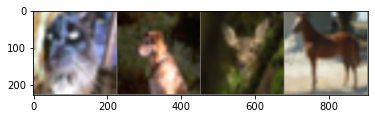

  cat   dog  deer horse


In [12]:
# display some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Define model

In [15]:
device = "cuda:1"
x = torch.randn(16,3,224,224).to(device)
model = ViT(n_head = 6).to(device)
output = model(x)
print(output.shape)

torch.Size([16, 10])


### Define Loss and optimizer

In [16]:
import torch.optim as optim

# define a loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Training

In [17]:
### Train the network
print('Start Training ')
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # Fill this loop
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # print statistics
        if i % 50 == 0:
            print('[%d, %5d] loss: %.6f' %
                 (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

Start Training 
[1,     1] loss: 0.004927
[1,    51] loss: 0.296211


KeyboardInterrupt: 

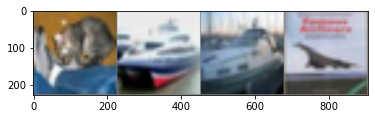

GrondTruth:    cat  ship  ship plane


In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()

#print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
images = images.to(device)
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4))) 

Predicted:    car   car   car   car
